# Data Visualization and Analysis for the Drinks Storage project
This notebook visualizes and analyzes data from two unified sources: Git and Grafana.

In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import pylab as plt

import matplotlib.gridspec as gridspec
import matplotlib.dates as dates
from IPython.display import HTML, display
import tabulate

In [3]:
PLT_FIGSIZE = (14, 4)
PLT_GS_W = 5
PLT_DPI = 250
PLT_ALPHA_MAX = .3
PLT_ALPHA_SCALE = .3
PLT_DATE_FMT = dates.DateFormatter('%Y-%m-%d')
DSV_DIR = 'data'
DSV_DELIMITER = ';'
DSV_GIT = f'{DSV_DIR}/drinks-storage-git.dsv'
DSV_GRAFANA_RAW = f'{DSV_DIR}/drinks-storage-grafana-raw.dsv'
DSV_GRAFANA_CRATES = f'{DSV_DIR}/drinks-storage-grafana-crates.dsv'
SEG_CUTOFF_SECONDS = 60 # Cutoff for individual segments in seconds
SEG_CUTOFF_SAMPLES = 8 # Cutoff for individual segments in number of samples
SEG_SIGNIFICANCE = 1.9 # Factor for std to be seen as significant for segmentation
SEG_MIN_STD = 1000 # Minimum std to cap outliers
DS_CRATE_KG = 24000 # Raw units for 1kg (rough estimate)

In [4]:
def newfig(fig_height=1):
    return plt.figure(dpi=PLT_DPI,
                      figsize=(PLT_FIGSIZE[0], PLT_FIGSIZE[1] * fig_height))

In [5]:
# Dataframe gIt
di = pd.read_csv(DSV_GIT, sep=DSV_DELIMITER, na_values='None')
print(di.name.unique())
print(len(di.name.unique()))

['apfelschorle' 'becks' 'eschweger' 'jacobinus' 'jever' 'mineralwasser'
 'mio_banane' 'mio_ginger' 'mio_mate' 'radler' 'koestritzer' 'mio_cola'
 'jever_fun' 'grapefruit_sprudel']
14


In [6]:
# Dataframe Grafana Raw
dgr = pd.read_csv(DSV_GRAFANA_RAW, sep=DSV_DELIMITER, na_values='None')
print(dgr.name.unique())
print(len(dgr.name.unique()))

['mio_cola' 'mio_mate' 'mio_ginger' 'apfelschorle' 'jever_fun'
 'mineralwasser' 'grapefruit_sprudel']
7


In [7]:
# Dataframe Grafana Crates
dgc = pd.read_csv(DSV_GRAFANA_CRATES, sep=DSV_DELIMITER, na_values='None')
# Drop total crate count
dgc = dgc.loc[dgc.name != 'Total']
print(dgc.name.unique())
print(len(dgc.name.unique()))

['becks' 'eschweger' 'jacobinus' 'jever' 'radler' 'koestritzer'
 'mio_guarana' 'mio_cola' 'mio_mate' 'mio_ginger' 'apfelschorle'
 'jever_fun' 'mineralwasser' 'grapefruit_sprudel']
14


#### Histograms
Visualize occurences of values for each scale.

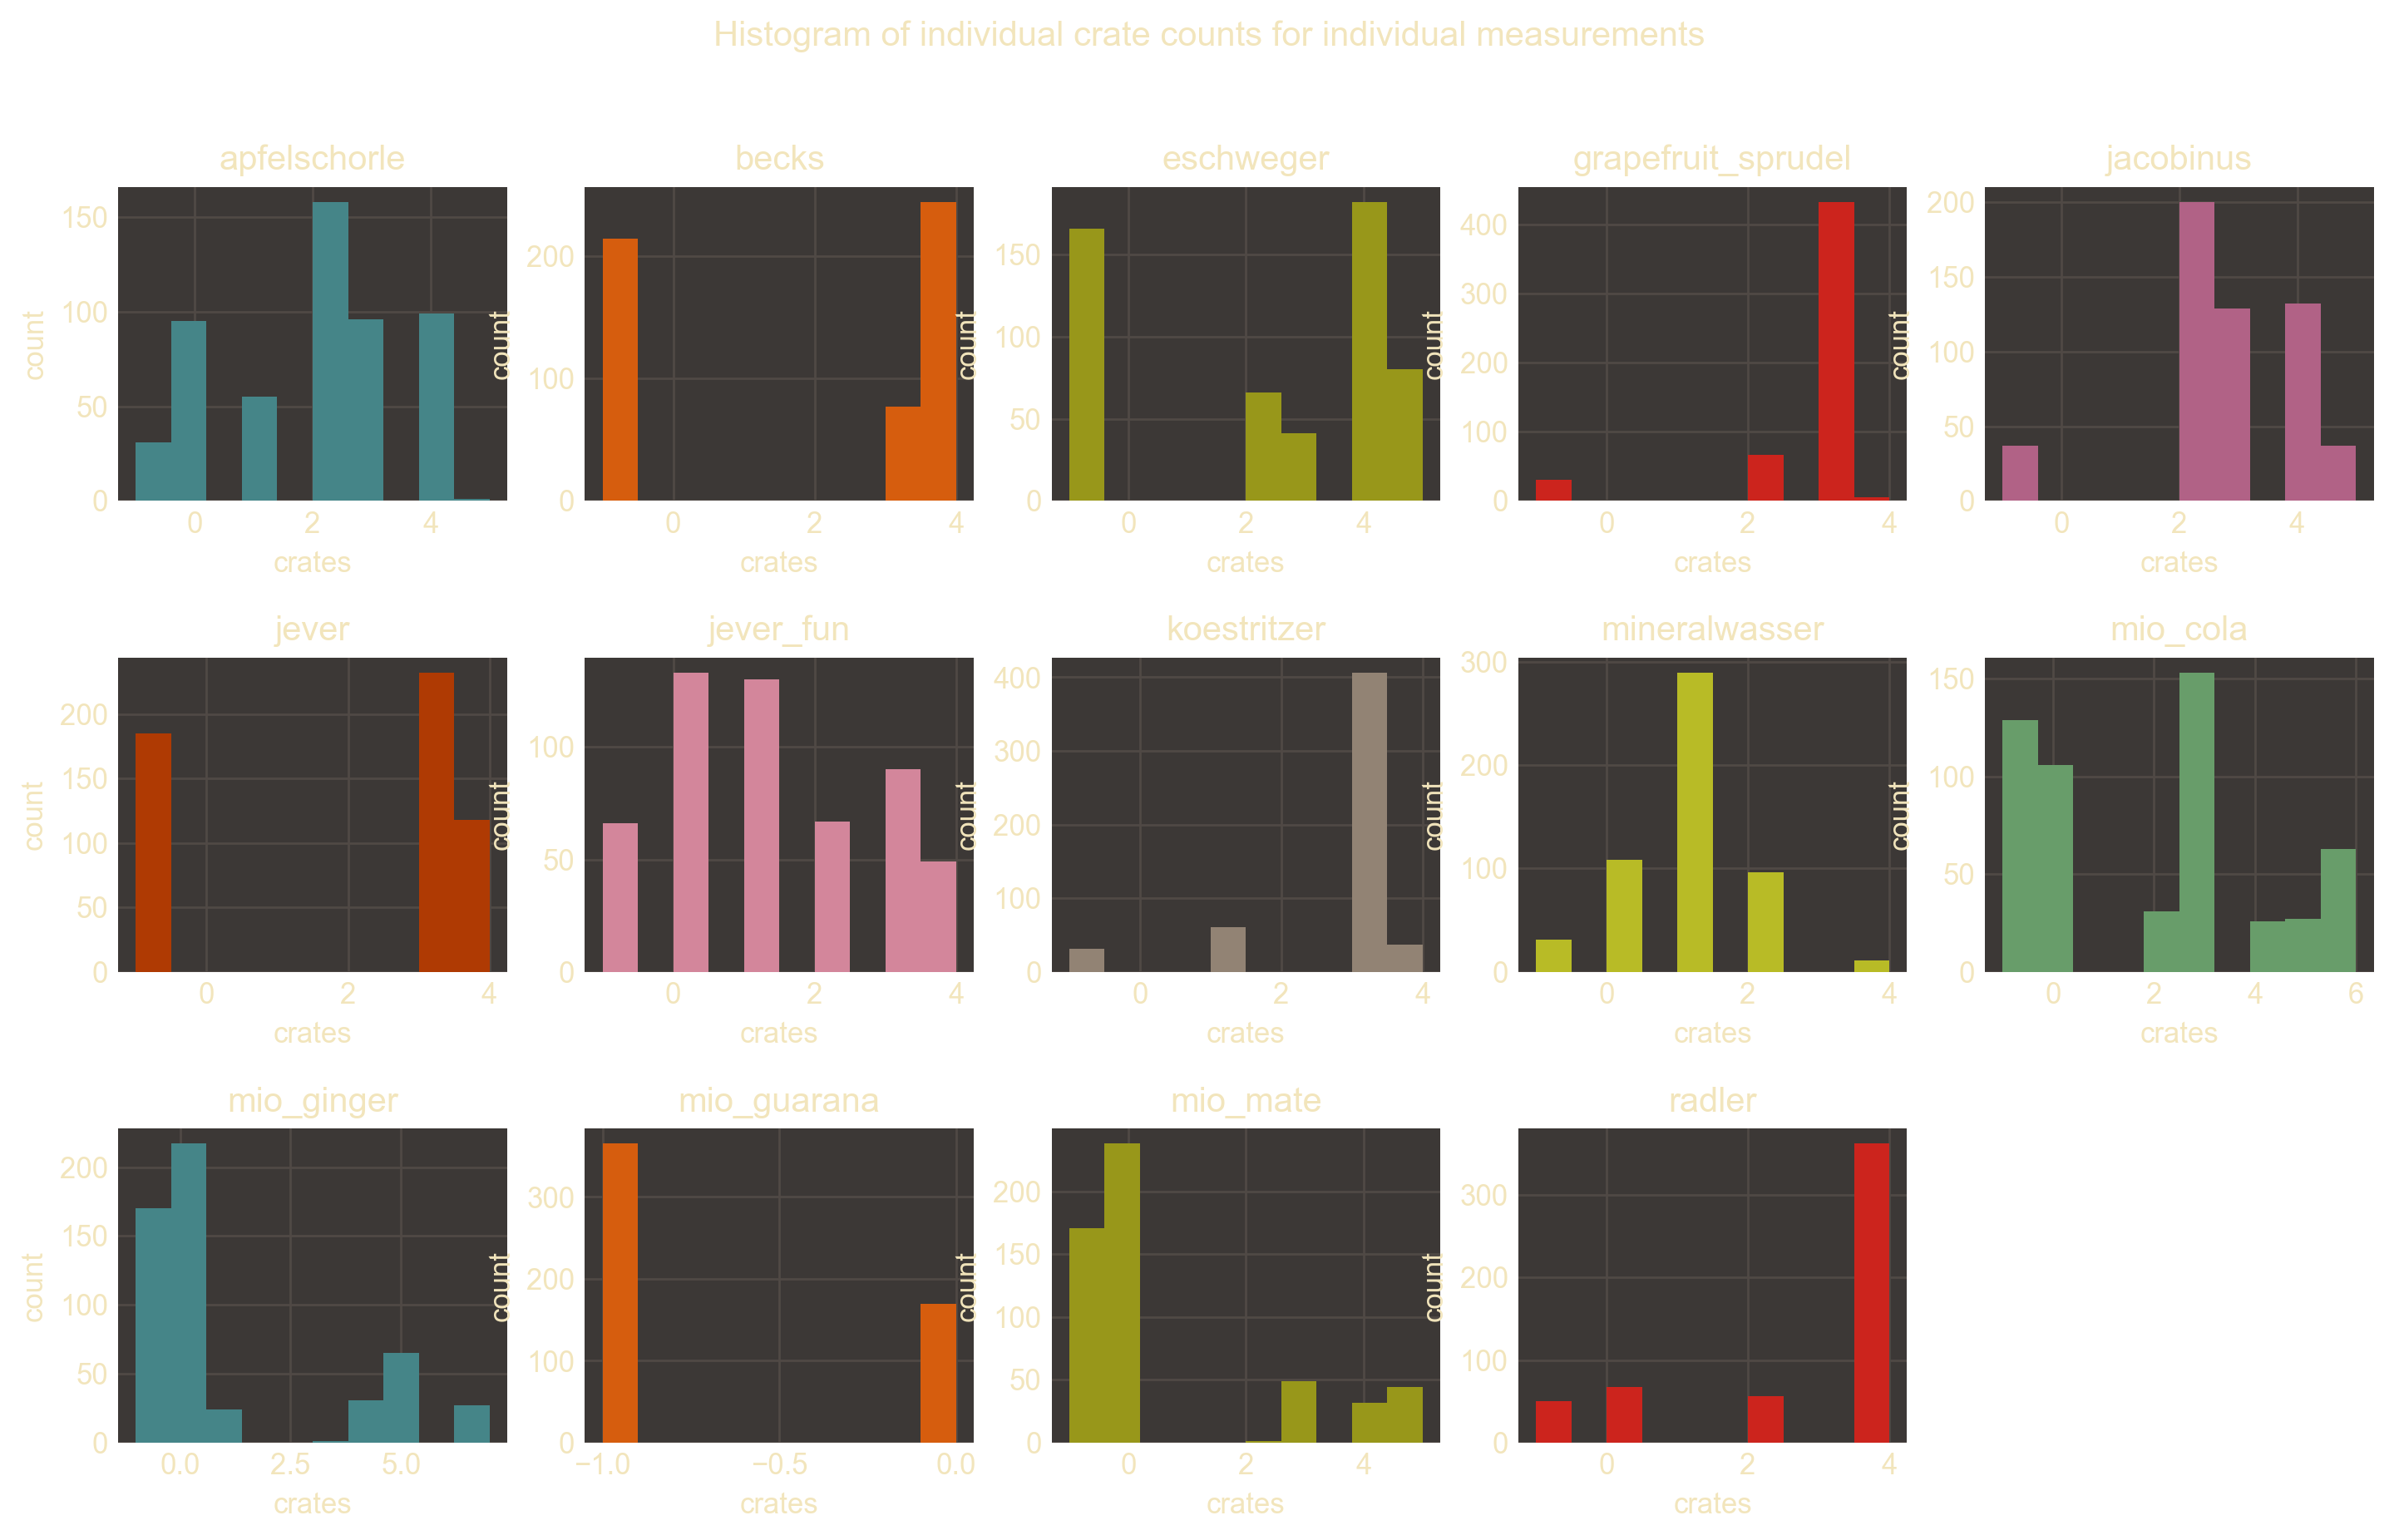

In [8]:
fig = newfig(fig_height=2)
iter_data = dgc.groupby('name').value
gs = gridspec.GridSpec(round(len(iter_data) / PLT_GS_W), PLT_GS_W, hspace=.5)
fig.suptitle('Histogram of individual crate counts for individual measurements')
for i, (name, values) in enumerate(iter_data):
    x = i % PLT_GS_W
    y = i // PLT_GS_W
    ax = plt.subplot(gs[y, x])
    values.hist(color=f'C{i}')#, bins=range(0, 10))
    plt.title(name)
    plt.ylabel('count')
    plt.xlabel('crates')
plt.show()

In [9]:
# Faulty (value == -1) percentage
table = [['<b>name</b>', '<b>faulty % time</b>']]
for i, (name, values) in enumerate(iter_data):
    fault = values.value_counts().loc[-1]
    total = values.value_counts().sum()
    percentage = f'{fault / total * 100:.2f}'
    table.append([name, percentage])
    
# Mark outliers beyond pi times std
percentages = []
for name, percentage in table[1:]:
    percentages.append(float(percentage))
percentages = np.array(percentages)
threshold = np.std(percentages) * np.pi
for i, (name, percentage) in enumerate(table[1:]):
    if float(percentage) > threshold:
        table[i + 1][1] = f'<b>{percentage}</b>'

display(HTML('<h3>Faulty scales</h3>'))
display(HTML(tabulate.tabulate(table, tablefmt='html')))

name,faulty % time
apfelschorle,5.79
becks,40.00
eschweger,31.03
grapefruit_sprudel,5.79
jacobinus,6.92
jever,34.58
jever_fun,12.34
koestritzer,5.79
mineralwasser,5.79
mio_cola,24.11


## Time Series Segmentation

In [10]:
def plot_segmentation(name, values, surpass_idx, seg_ts, seg_ts_filt):
    fig, ax = plt.subplots(figsize=PLT_FIGSIZE, dpi=PLT_DPI)
    plt.plot(
        dates.epoch2num(values.ts),
        diff,
        label='raw sensor data (1st derivative)',
    )
    plt.hlines(
        threshold,
        dates.epoch2num(values.iloc[0].ts),
        dates.epoch2num(values.iloc[-1].ts),
        color='C3',
        label='threshold',
    )
    plt.vlines(
        dates.epoch2num(seg_ts),
        0,
        diff.loc[surpass_idx].max(),
        color='C4',
        label='segments',
    )
    plt.vlines(
        dates.epoch2num(seg_ts_filt),
        0,
        diff.loc[surpass_idx].max(),
        color='C7',
        label='segments (filtered)',
    )
    plt.plot(
        dates.epoch2num(values.loc[surpass_idx].ts),
        diff.loc[surpass_idx],
        'o',
        label='values surpassing threshold',
    )
    plt.title(name)
    ax.xaxis.set_major_formatter(PLT_DATE_FMT)
    plt.legend()
    plt.show()

In [11]:
# 1. Segmentation based on high change (first derivative)
# Dataframe SEGmentation
dseg = pd.DataFrame(columns=['name', 'ts_start', 'ts_end'])
iter_data = dgr.groupby('name')
j = 0
#cutoff_seconds = SEG_CUTOFF_SECONDS
significance = SEG_SIGNIFICANCE
for i, (name, values) in enumerate(iter_data):
    diff = values.value.diff().abs()
    threshold = diff.std() * significance
    surpass_idx = diff.loc[diff > threshold].index
    seg_ts = values.loc[surpass_idx].ts
    # # Set minimum length for segments and filter too short segments
    # seg_min_len = seg_ts.diff().value_counts().index[0]
    # seg_ts_filt = seg_ts.loc[seg_ts.diff() > seg_min_len]
    # Filtering would omit important segments
    seg_ts_filt = seg_ts
    # Visualize segmentation process
    # plot_segmentation(name, values, surpass_idx, seg_ts, seg_ts_filt)
    
    # Storing of segments
    ts_first = values.ts.min()
    ts_last = values.ts.max()
    ts_prev = seg_ts_filt.iloc[0]
    #dseg.loc[j] = [name, ts_first + cutoff_seconds, ts_prev - cutoff_seconds]
    dseg.loc[j] = [name, ts_first, ts_prev]
    j += 1
    for ts in seg_ts_filt.iloc[1:]:
        #dseg.loc[j] = [name, ts_prev + cutoff_seconds, ts - cutoff_seconds]
        dseg.loc[j] = [name, ts_prev, ts]
        ts_prev = ts
        j += 1
    #dseg.loc[j] = [name, ts + cutoff_seconds, ts_last - cutoff_seconds]
    dseg.loc[j] = [name, ts, ts_last]

In [12]:
def plot_segments(name, seg_values):
    # Visualization (Part 1)
    x_min = seg_values.index.min()
    x_max = seg_values.index.max()
    
    newfig()
    plt.title(f'{name} (raw signal)')
    (seg_values.value.abs() / DS_CRATE_KG).plot()
    plt.legend()
    
    newfig()
    seg_values.value.diff().plot()
    plt.hlines(seg_values.value.diff().mean(), 0, x_max, color='C1', label='mean')

    # Show std if spikes overshoot minimum threshold
    threshold = seg_values.value.diff().std() * np.pi
    # if threshold > SEG_MIN_STD:
    plt.hlines(threshold, 0, x_max, color='C2', label='std * π')
    plt.hlines(-threshold, 0, x_max, color='C2', label='-std * π')

    # Visualization (Part 2)
    plt.title(f'{name} (1st derivative)')
    plt.legend()
    plt.show()

In [13]:
# 2. Statistical properties (std, mean, ...)
cutoff_samples = SEG_CUTOFF_SAMPLES
dseg['std'] = 0
for i, (name, values) in enumerate(dseg.groupby('name')):
    for j, row in values.iterrows():
        # Boundary conditions for segments
        c_name = dgr.name == name
        c_ts_start = dgr.ts > row.ts_start
        c_ts_end = dgr.ts < row.ts_end
        seg_values = dgr[c_name & c_ts_start & c_ts_end]
        
        # Discard segment if length less than total cutoff (left/right)
        # or no data at all
        if len(seg_values) <= cutoff_samples * 2:
            continue
        
        # Cut off number of samples
        seg_values = seg_values.iloc[cutoff_samples:-cutoff_samples]
        
        # Add new std value for time series segments
        dseg.at[j, 'std'] = seg_values.value.std()
        
        # Visualize
        # plot_segments(name, seg_values)

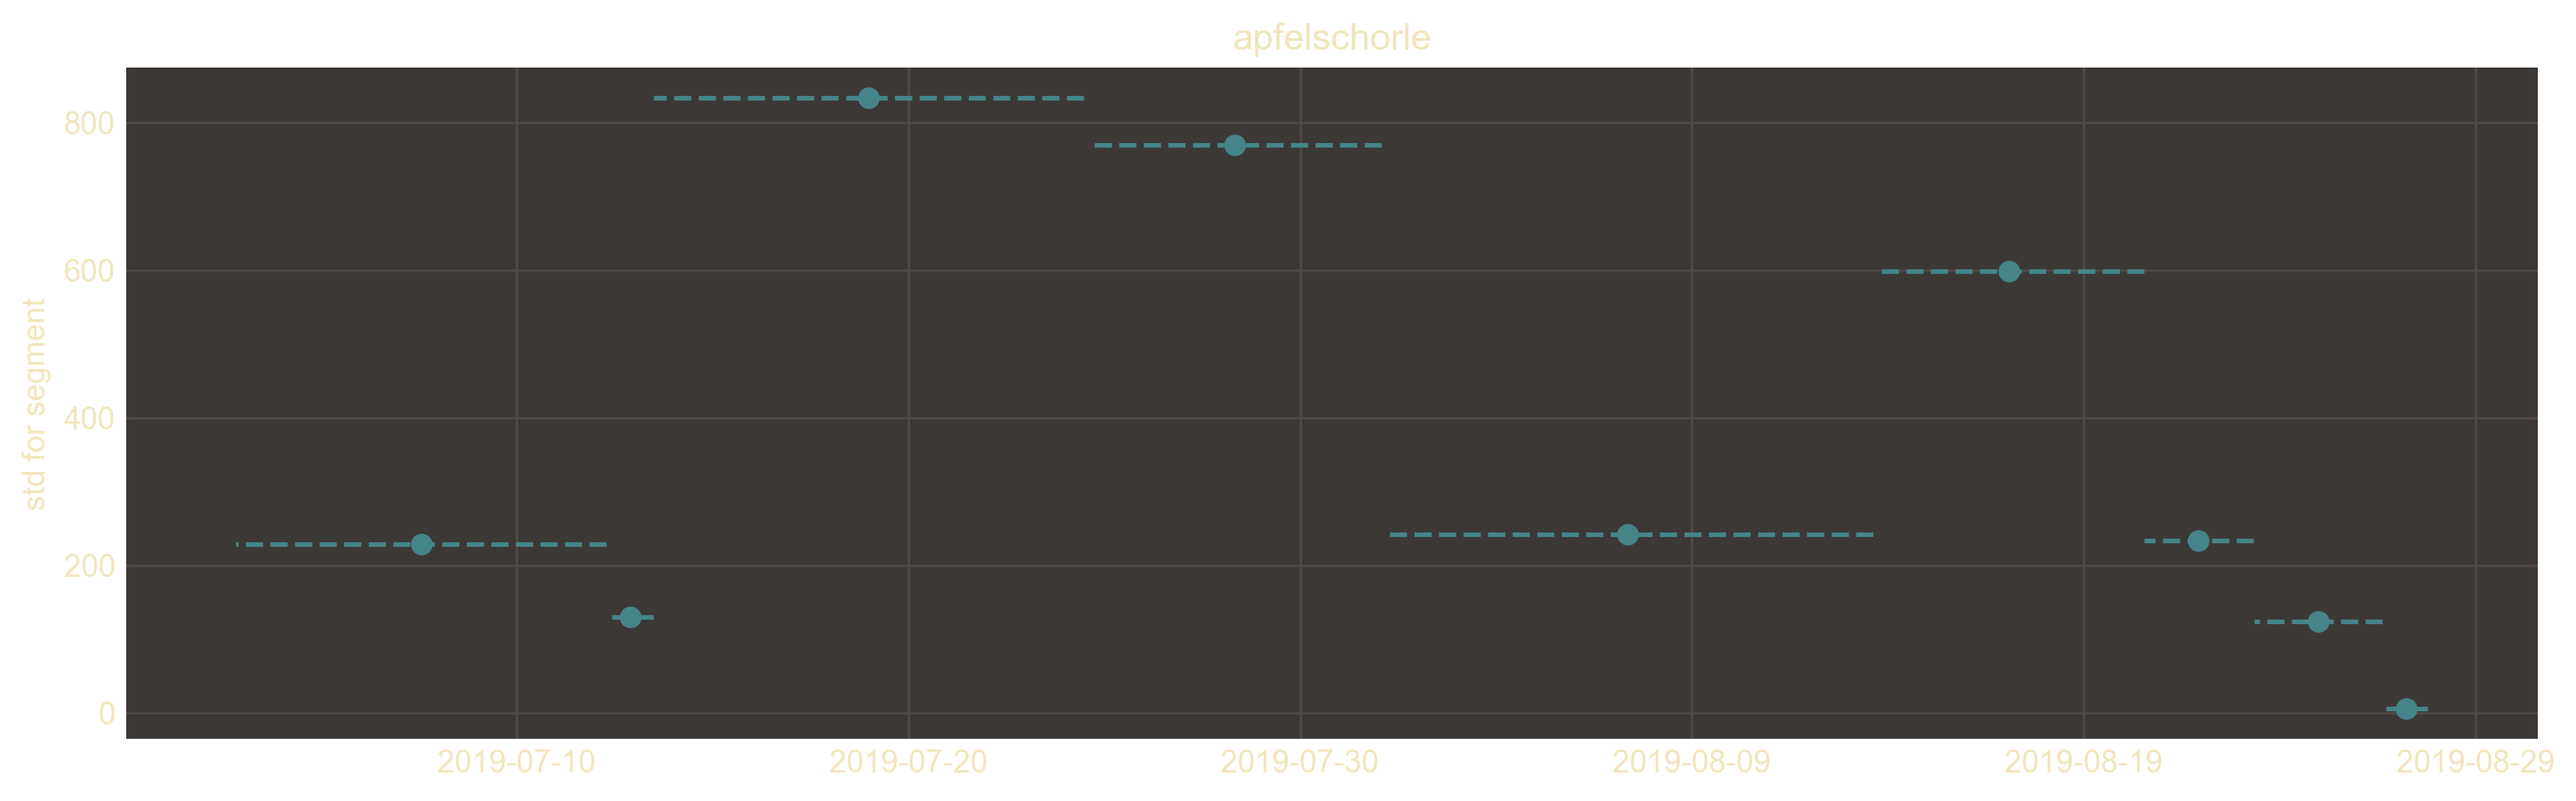

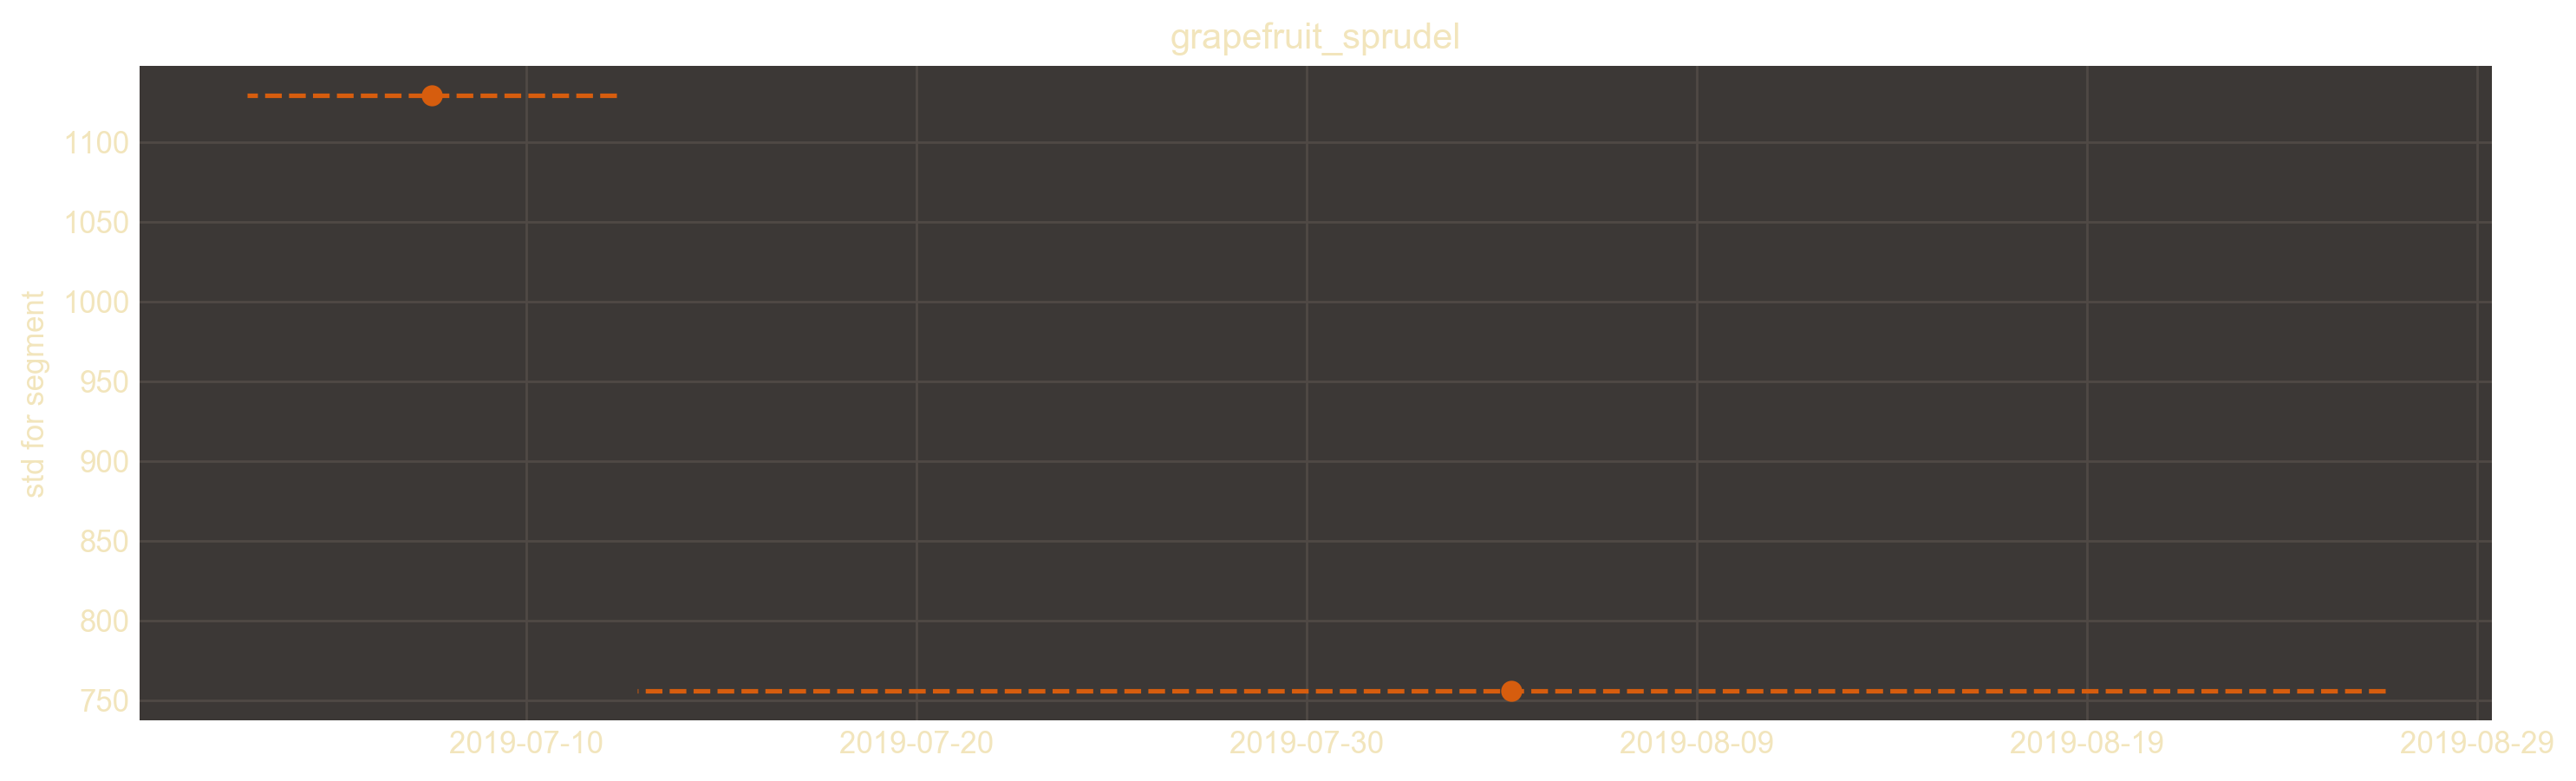

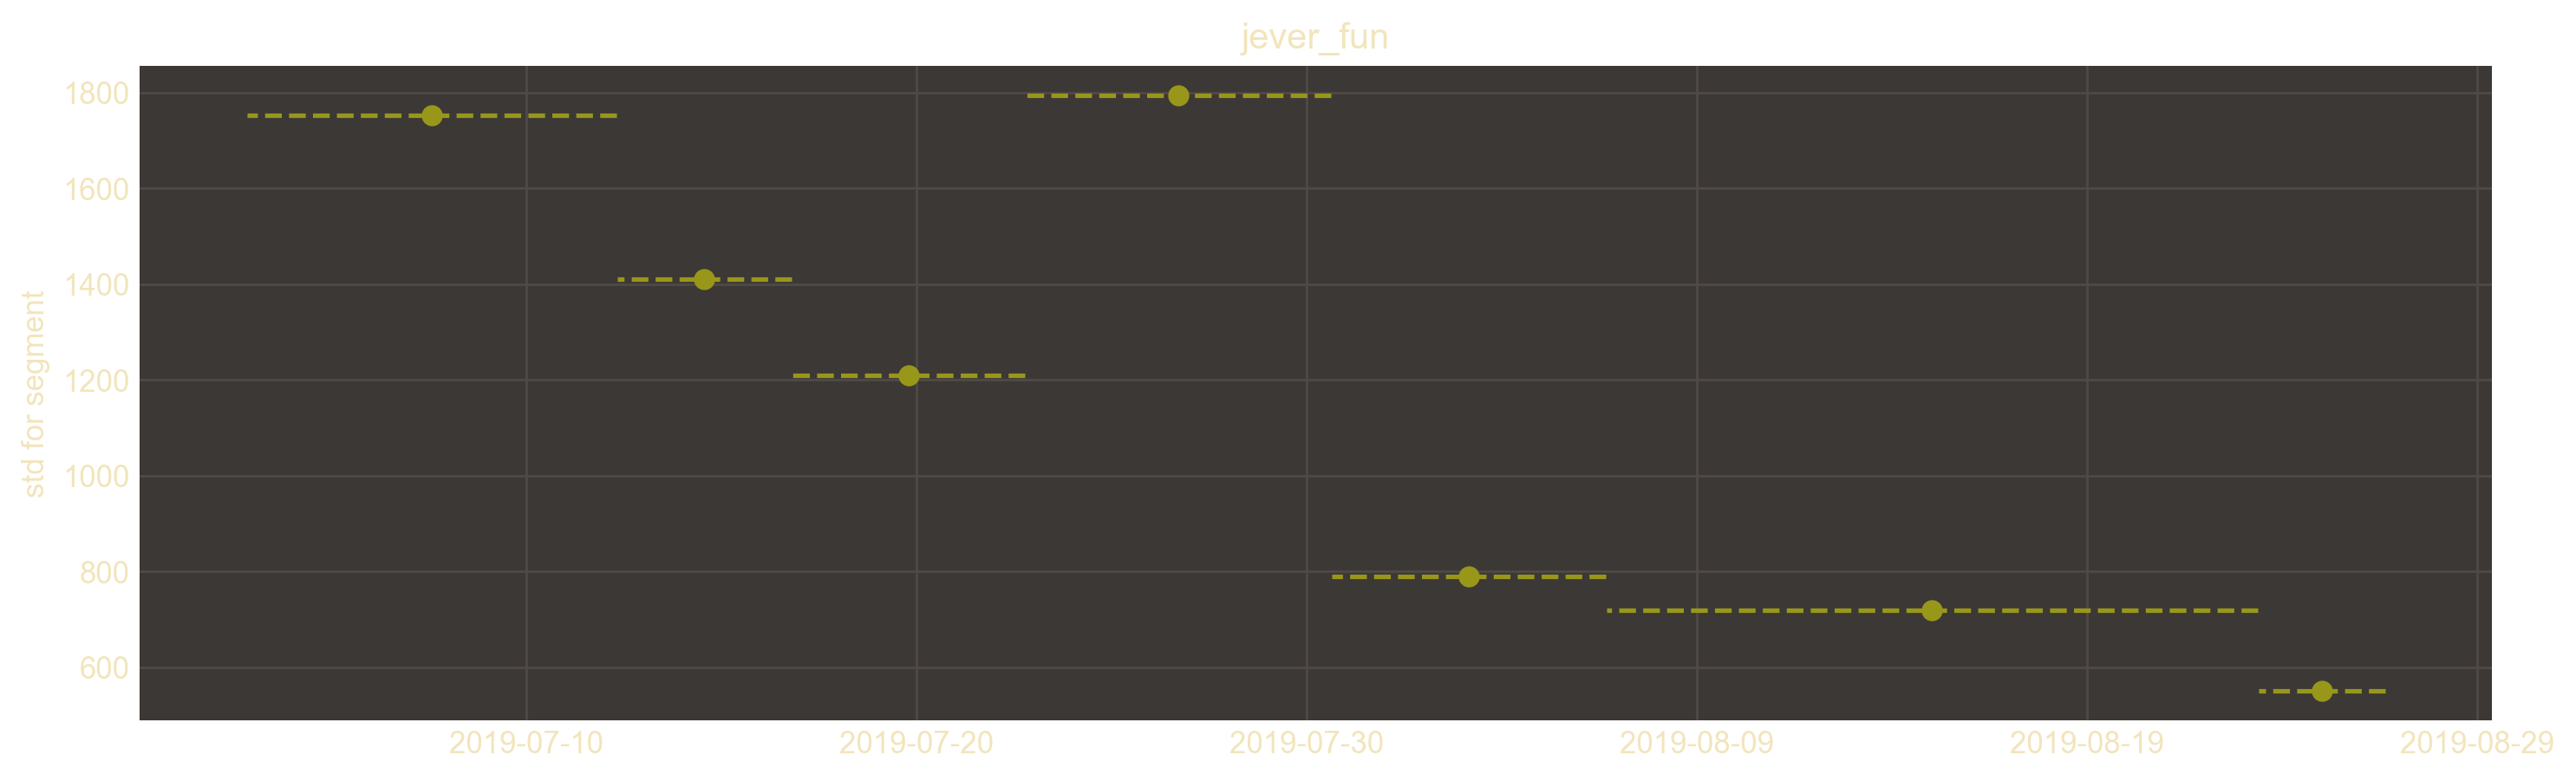

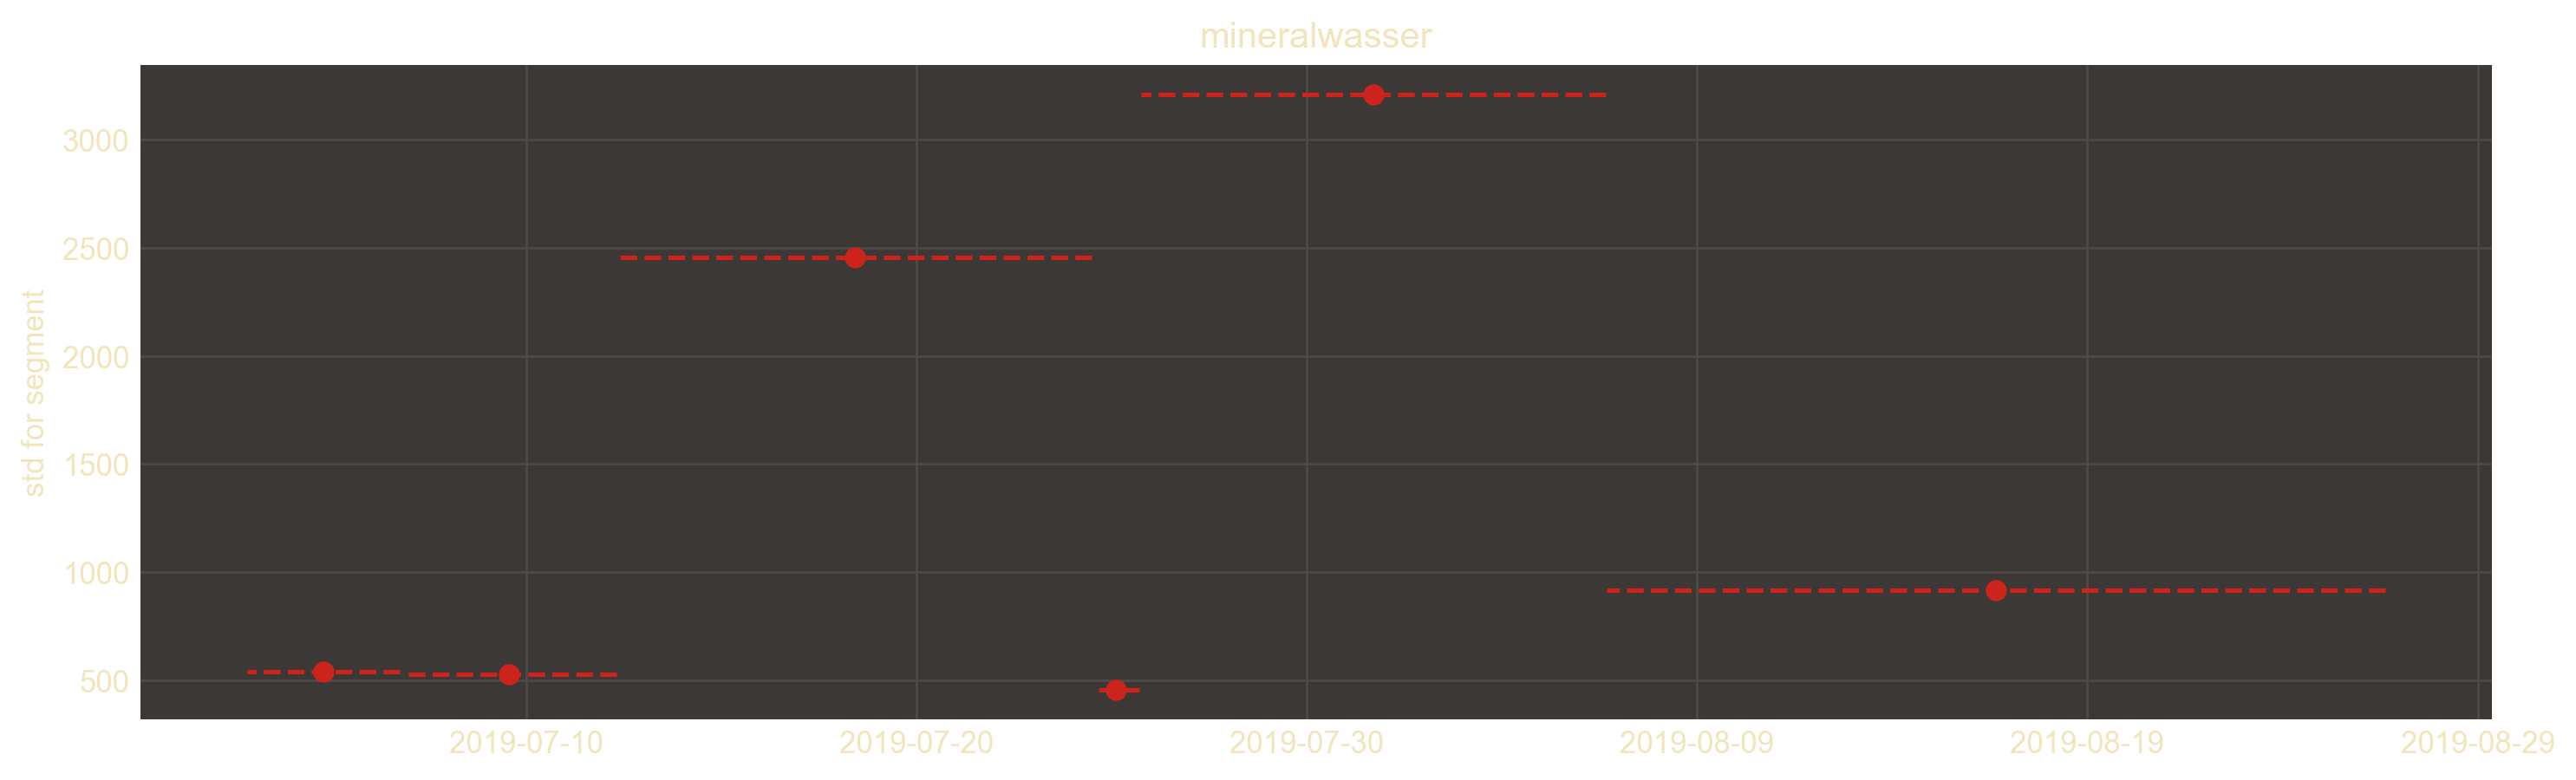

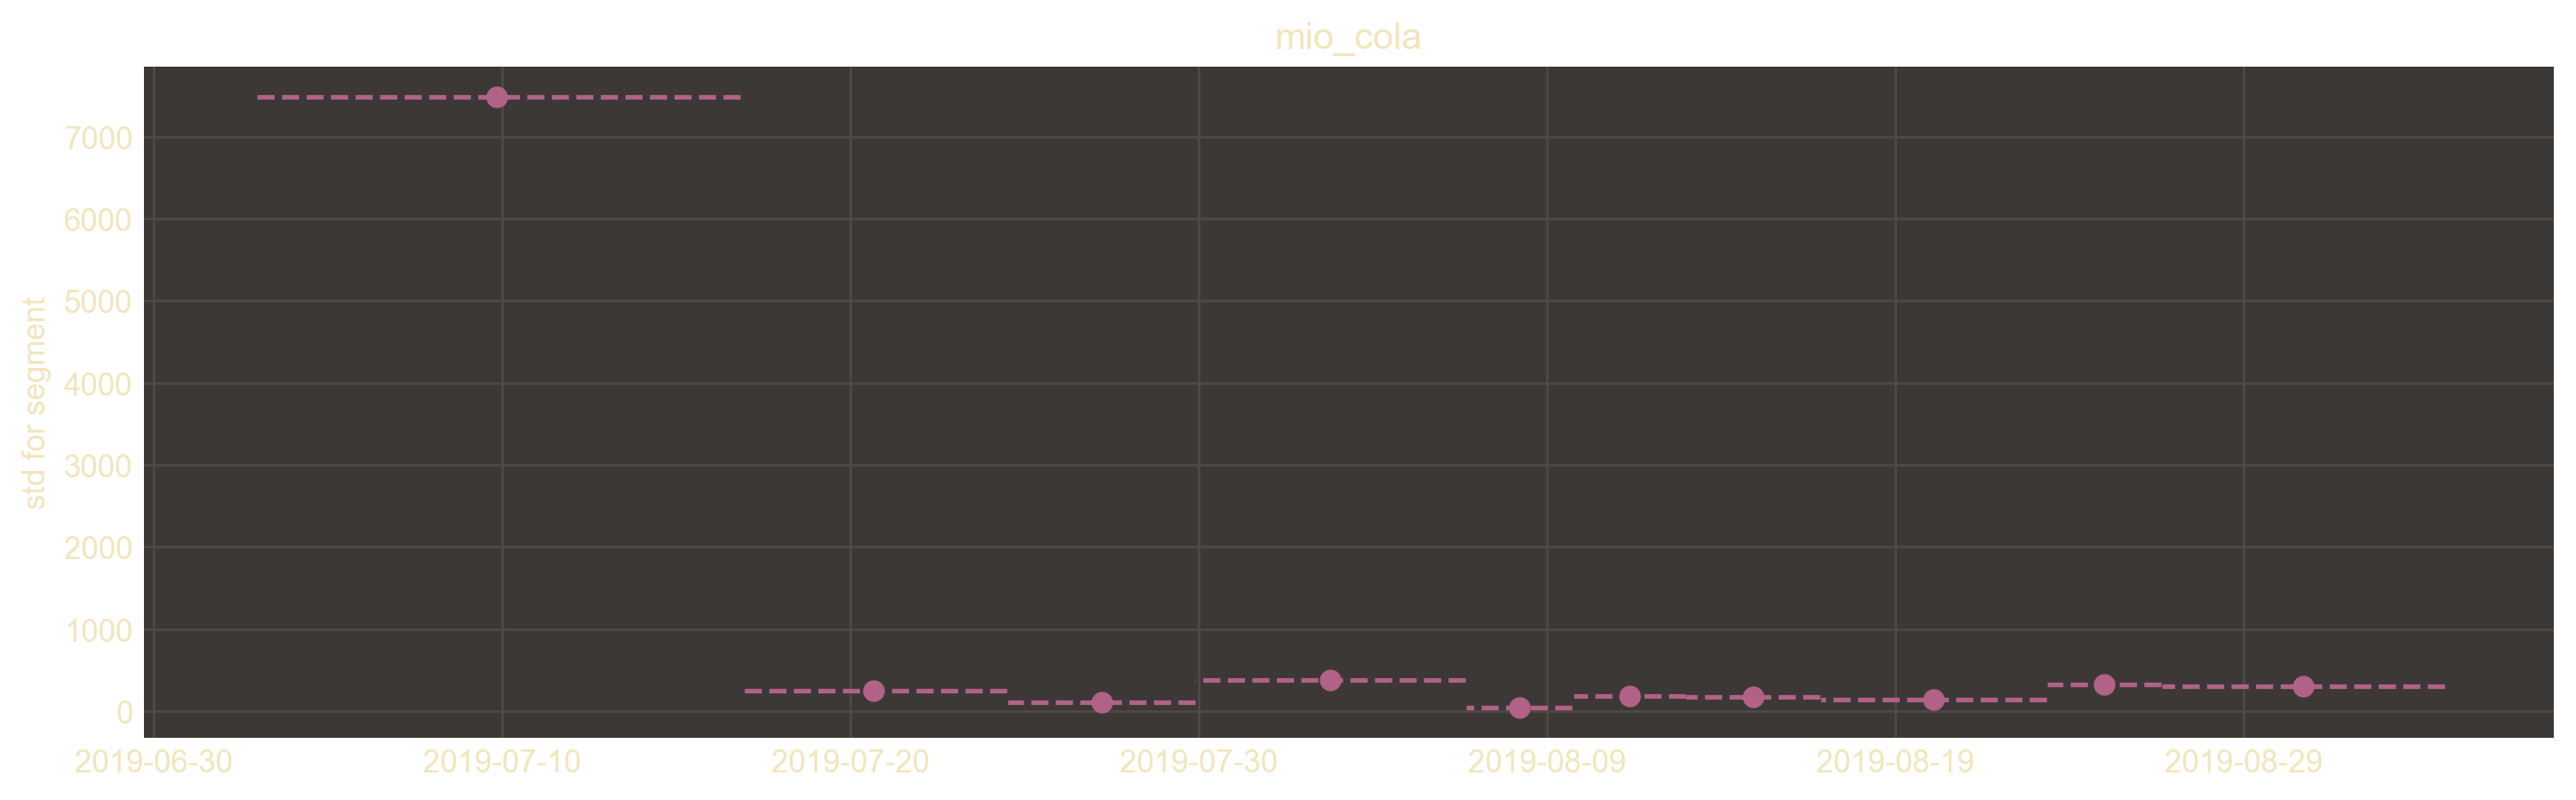

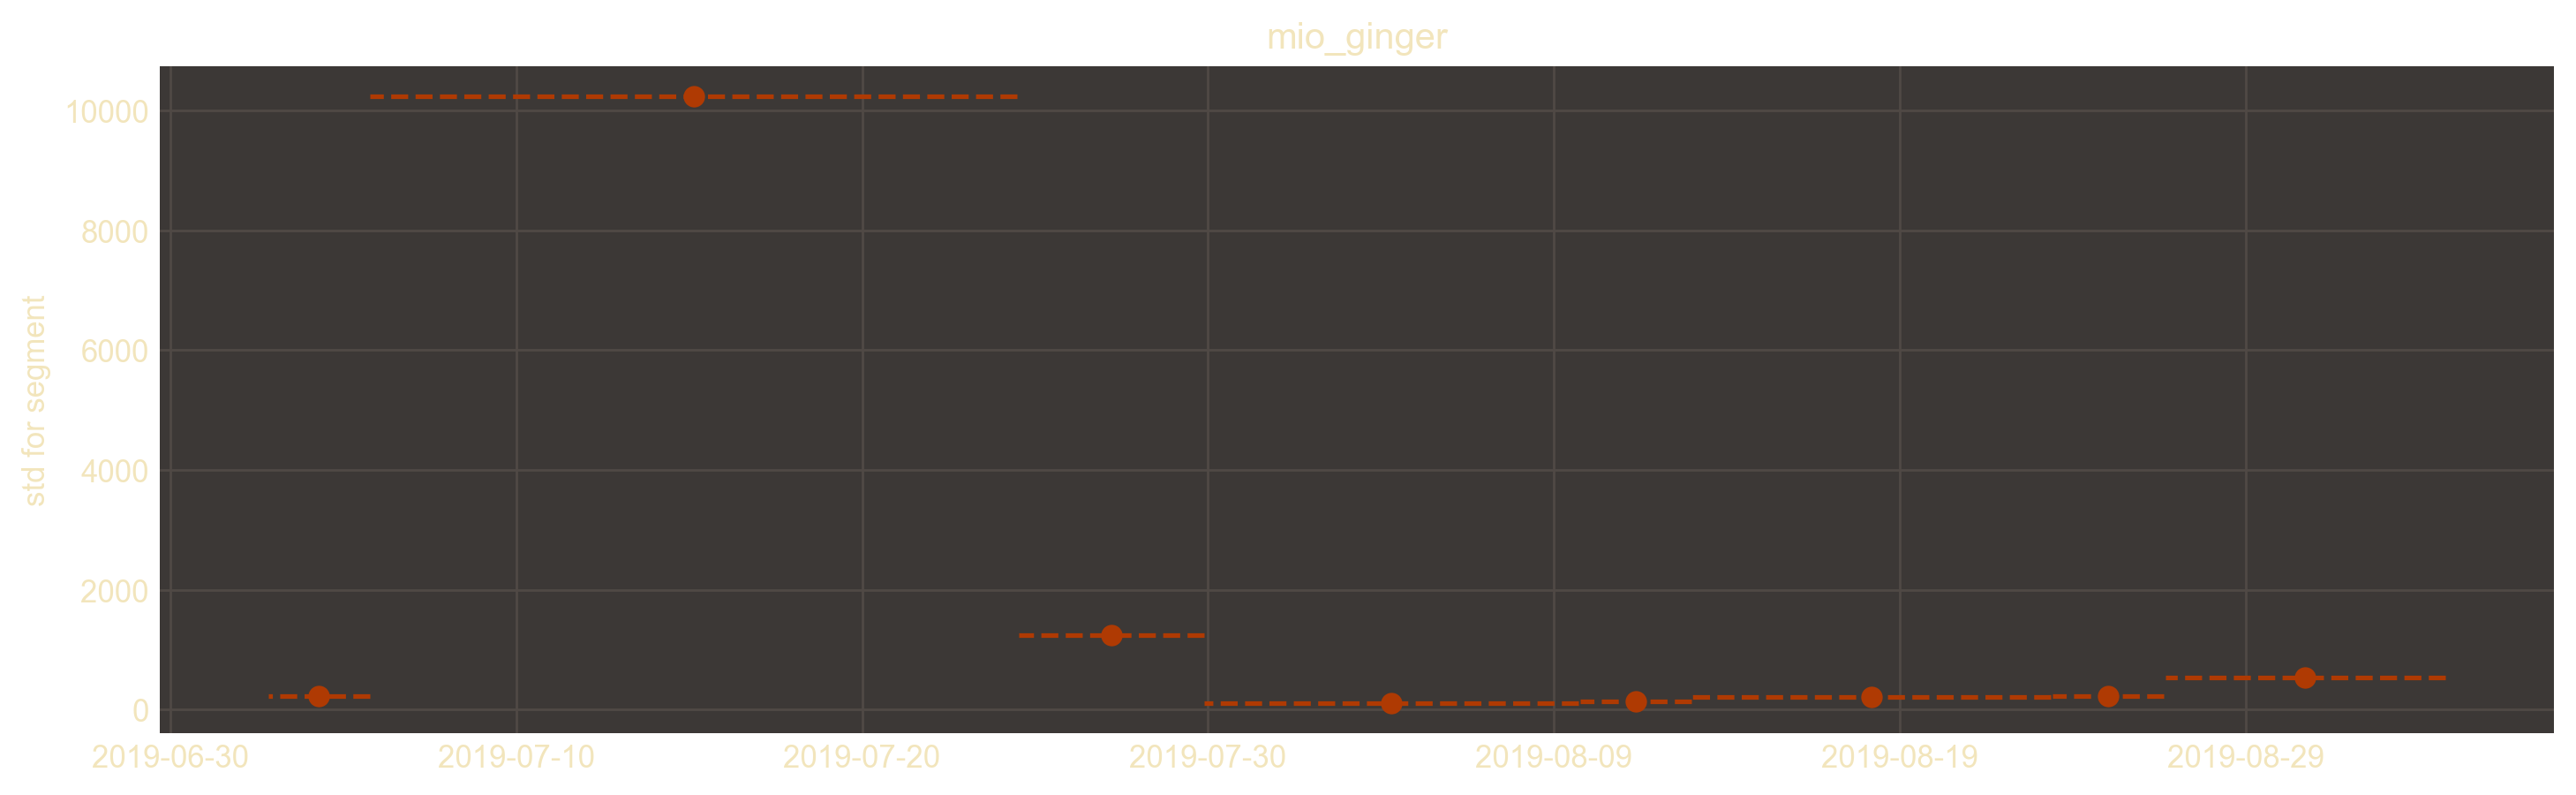

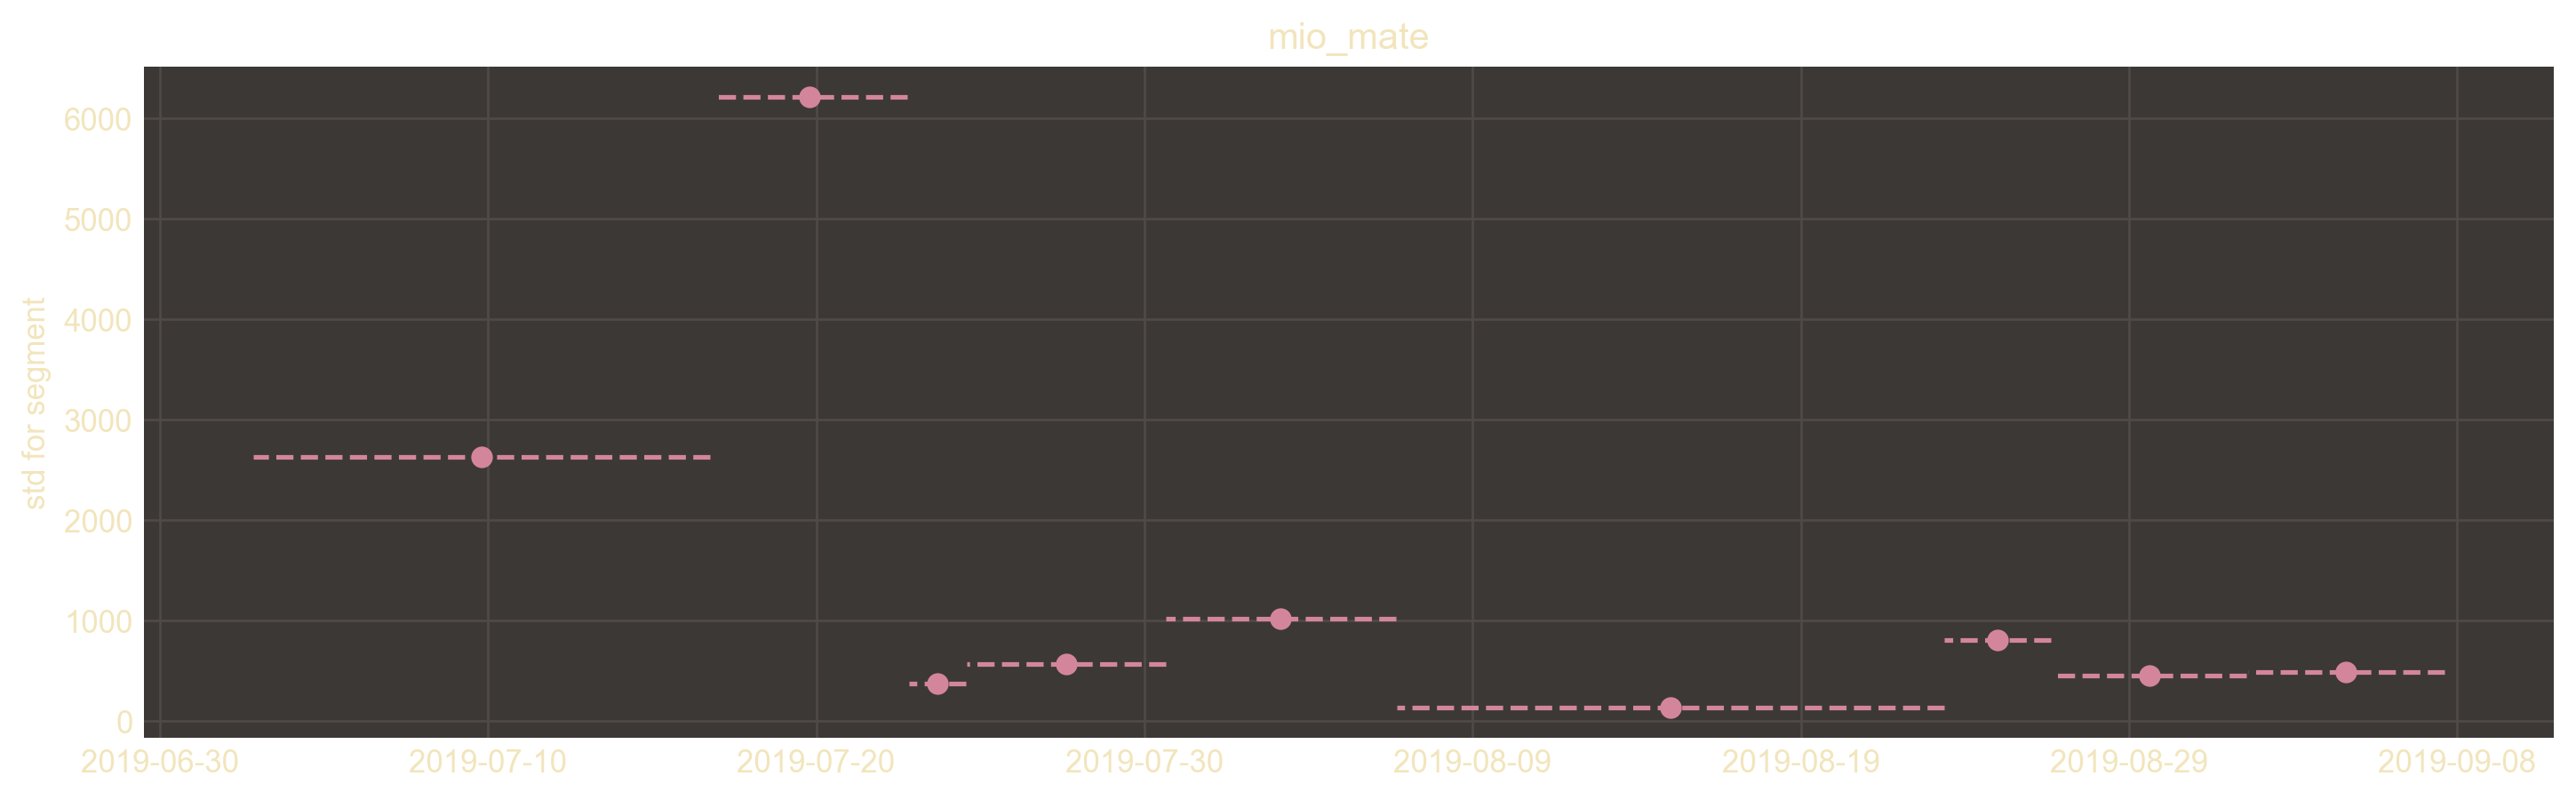

In [22]:
# Visualize history
display(HTML('<h3>Development of standard deviation over time (segment based)</h3>'))
for i, (name, values) in enumerate(dseg.groupby('name')):
    # Collect relevant data
    filter_name = values.name == name
    filter_std = values['std'] > 0
    values_relevant = values.loc[filter_name & filter_std]
    
    # Visualize
    fig, ax = plt.subplots(figsize=PLT_FIGSIZE, dpi=PLT_DPI)
    ts_mean = (values_relevant.ts_end - values_relevant.ts_start) // 2 + values_relevant.ts_start,
    plt.title(name)
    plt.ylabel('std for segment')
    plt.scatter(
        dates.epoch2num(ts_mean),
        values_relevant['std'],
        c=f'C{i}',
    )
    plt.hlines(
        values_relevant['std'],
        dates.epoch2num(values_relevant.ts_end),
        dates.epoch2num(values_relevant.ts_start),
        color=f'C{i}',
        linestyles='--',
    )
    ax.xaxis.set_major_formatter(PLT_DATE_FMT)
    plt.show()

#### Conclusion
Standard deviation has not increased over the last three months. This hints that the sensors did not develop or increase noise levels . Sensor drift still has to be analyzed.